In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 2GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
train_dir = "../data/train"
val_dir = "../data/val"
test_dir = "../data/test"

In [4]:
train_df = pd.read_csv("../data/train.csv", index_col=0)
val_df = pd.read_csv("../data/val.csv", index_col=0)
test_df = pd.read_csv("../data/test.csv", index_col=0)

In [6]:
dfs = [train_df, val_df, test_df]
result_dfs = []

for df in [train_df, val_df, test_df]:
    df['id'] = df.index
    df['id'] = df['id'].apply(lambda x: x+".jpg")
    result_dfs.append(df)

In [7]:
train_df = result_dfs[0]
val_df = result_dfs[1]
test_df = result_dfs[2]

In [10]:
train_df.head()

,dist_0,ABS_RX,ABS_Y,id
2020-06-16_08-59-11-257177,2221.29,-0.2,0.6,2020-06-16_08-59-11-257177.jpg
2020-06-16_08-59-12-485854,113.47,1.0,0.6,2020-06-16_08-59-12-485854.jpg
2020-06-16_08-59-13-612812,115.79,-0.9,0.6,2020-06-16_08-59-13-612812.jpg
2020-06-16_08-59-14-730263,2219.64,-0.9,0.6,2020-06-16_08-59-14-730263.jpg
2020-06-16_08-59-15-971140,177.91,0.1,0.6,2020-06-16_08-59-15-971140.jpg


In [37]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False,)

train_generator = train_datagen.flow_from_dataframe(dataframe=train_df, directory=train_dir, 
                                              x_col="id", y_col="ABS_RX",
                                              class_mode="other", # "categorical"
                                              target_size=(224, 224), 
                                              batch_size=32)


val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_dataframe(dataframe=val_df, directory=val_dir, 
                                              x_col="id", y_col="ABS_RX", 
                                              class_mode="other", target_size=(224, 224), 
                                              batch_size=32)

Found 2156 validated image filenames.
Found 300 validated image filenames.


In [23]:
from tensorflow.keras.applications.resnet50 import ResNet50

base_model = ResNet50(weights="../models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5", 
                      include_top=False,
                      input_shape=(224, 224, 3))

In [24]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [30]:
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1))

In [31]:
base_model.trainable = False

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               12845184  
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 36,433,025
Trainable params: 12,845,313
Non-trainable params: 23,587,712
_________________________________________________________________


In [35]:
model.compile(loss="mse",
              optimizer=optimizers.RMSprop(lr=0.0001))
              #metrics=['mean_squared_error'])

In [38]:
history = model.fit(train_generator, 
                              steps_per_epoch=67, 
                              epochs=200, 
                              validation_data=val_generator, 
                              validation_steps=9)

Epoch 1/200
67/67 [==============================] - 18s 266ms/step - loss: 4.1552 - val_loss: 0.2935
Epoch 2/200
67/67 [==============================] - 17s 261ms/step - loss: 0.2925 - val_loss: 0.2376
Epoch 3/200
67/67 [==============================] - 17s 257ms/step - loss: 0.2909 - val_loss: 0.2168
Epoch 4/200
67/67 [==============================] - 17s 256ms/step - loss: 0.2683 - val_loss: 0.1946
Epoch 5/200
67/67 [==============================] - 17s 257ms/step - loss: 0.2553 - val_loss: 0.1952
Epoch 6/200
67/67 [==============================] - 17s 256ms/step - loss: 0.2576 - val_loss: 0.1965
Epoch 7/200
67/67 [==============================] - 17s 261ms/step - loss: 0.2493 - val_loss: 0.1698
Epoch 8/200
67/67 [==============================] - 17s 258ms/step - loss: 0.2395 - val_loss: 0.1643
Epoch 9/200
67/67 [==============================] - 17s 255ms/step - loss: 0.2408 - val_loss: 0.1597
Epoch 10/200
67/67 [==============================] - 17s 254ms/step - loss: 0.239

67/67 [==============================] - 17s 258ms/step - loss: 0.1944 - val_loss: 0.1360
Epoch 81/200
67/67 [==============================] - 17s 255ms/step - loss: 0.1952 - val_loss: 0.1370
Epoch 82/200
67/67 [==============================] - 17s 252ms/step - loss: 0.1950 - val_loss: 0.1706
Epoch 83/200
67/67 [==============================] - 17s 256ms/step - loss: 0.1967 - val_loss: 0.1423
Epoch 84/200
67/67 [==============================] - 17s 257ms/step - loss: 0.1900 - val_loss: 0.1500
Epoch 85/200
67/67 [==============================] - 17s 259ms/step - loss: 0.1909 - val_loss: 0.1322
Epoch 86/200
67/67 [==============================] - 17s 257ms/step - loss: 0.1940 - val_loss: 0.1258
Epoch 87/200
67/67 [==============================] - 17s 260ms/step - loss: 0.1902 - val_loss: 0.1310
Epoch 88/200
67/67 [==============================] - 18s 262ms/step - loss: 0.1925 - val_loss: 0.1291
Epoch 89/200
67/67 [==============================] - 17s 256ms/step - loss: 0.1915 - 

67/67 [==============================] - 17s 257ms/step - loss: 0.1825 - val_loss: 0.1297
Epoch 160/200
67/67 [==============================] - 17s 259ms/step - loss: 0.1789 - val_loss: 0.1508
Epoch 161/200
67/67 [==============================] - 17s 257ms/step - loss: 0.1804 - val_loss: 0.1597
Epoch 162/200
67/67 [==============================] - 17s 259ms/step - loss: 0.1761 - val_loss: 0.1942
Epoch 163/200
67/67 [==============================] - 17s 256ms/step - loss: 0.1841 - val_loss: 0.1237
Epoch 164/200
67/67 [==============================] - 17s 257ms/step - loss: 0.1827 - val_loss: 0.1312
Epoch 165/200
67/67 [==============================] - 17s 260ms/step - loss: 0.1826 - val_loss: 0.1250
Epoch 166/200
67/67 [==============================] - 17s 260ms/step - loss: 0.1795 - val_loss: 0.1333
Epoch 167/200
67/67 [==============================] - 17s 260ms/step - loss: 0.1828 - val_loss: 0.1173
Epoch 168/200
67/67 [==============================] - 17s 258ms/step - loss: 

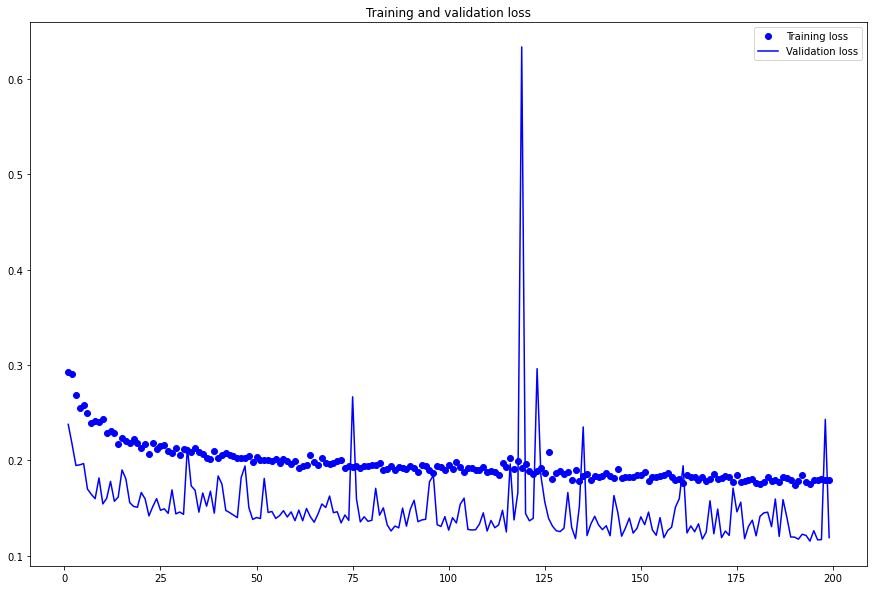

In [42]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))
plt.figure(figsize=(15,10))

plt.plot(epochs[1:], loss[1:], 'bo', label='Training loss')
plt.plot(epochs[1:], val_loss[1:], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()